### 1D CNN for classification

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import tqdm
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
class EIT_Autoencoder(nn.Module):
    def __init__(self, input_size=128, num_classes=10, latent_dim=128):
        super(EIT_Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # First encoding block
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            # Second encoding block
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            # Latent space
            nn.Linear(512, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Decoder (for unsupervised pre-training if needed)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, input_size),
            nn.Sigmoid()  # or Tanh() depending on input normalization
        )
        
        # Classification head
        self.classifier = nn.Linear(latent_dim, num_classes)
        
    def encode(self, x):
        """Extract latent representation"""
        # Flatten if input has channel dimension
        if len(x.shape) == 3:  # [batch, 1, input_size]
            x = x.squeeze(1)
        return self.encoder(x)
    
    def decode(self, z):
        """Reconstruct from latent representation"""
        return self.decoder(z)
    
    def forward(self, x):
        """Forward pass for classification"""
        # Flatten if input has channel dimension
        if len(x.shape) == 3:  # [batch, 1, input_size]
            x = x.squeeze(1)
        
        # Encode to latent space
        z = self.encoder(x)
        
        # Classify from latent representation
        out = self.classifier(z)
        
        return out
    
    def forward_with_reconstruction(self, x):
        """Forward pass returning both classification and reconstruction"""
        if len(x.shape) == 3:
            x = x.squeeze(1)
        
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        classification = self.classifier(z)
        
        return classification, reconstruction

In [4]:
class EIT_1DCNN(nn.Module):
    def __init__(self, input_size=128, num_classes=10):
        super(EIT_1DCNN, self).__init__()
        
        # First conv block - reduced channels
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.4)
        
        # Second conv block - reduced channels
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.4)
        
        # Calculate the flattened size after convolutions and pooling
        # 128 -> 64 -> 32
        self.flattened_size = 64 * 32
        
        # Simplified fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv blocks
        x = self.dropout1(self.pool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(self.relu2(self.bn2(self.conv2(x)))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = self.dropout_fc1(self.relu_fc1(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        
        return x

In [5]:
def prepare_data(X, y, test_size=0.2, val_size=0.15, batch_size=16):

    # Normalize the input data (important for noisy signals)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split into train, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=42, stratify=y
    )
    
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=42, stratify=y_temp
    )
    
    # Convert to PyTorch tensors and add channel dimension
    X_train_t = torch.FloatTensor(X_train).unsqueeze(1)  # Shape: (N, 1, 128)
    y_train_t = torch.LongTensor(y_train)
    
    X_val_t = torch.FloatTensor(X_val).unsqueeze(1)
    y_val_t = torch.LongTensor(y_val)
    
    X_test_t = torch.FloatTensor(X_test).unsqueeze(1)
    y_test_t = torch.LongTensor(y_test)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f'Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}')
    
    return train_loader, val_loader, test_loader, scaler

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=150, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, verbose=True
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    early_stop_patience = 30  # Stop if no improvement for 30 epochs
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 60)
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f'\nBest Validation Accuracy: {best_val_acc:.2f}%')
    
    return model, history

In [7]:
def test_model(model, test_loader, num_classes=10):

    model.eval()
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    test_acc = 100 * test_correct / test_total
    
    # Per-class metrics
    f1_per_class = f1_score(all_labels, all_predictions, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)
    
    # F1 Score (macro and weighted)
    f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    # Precision and Recall
    precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    precision_weighted = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall_weighted = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    
    # Mean Average Precision (mAP)
    # Convert labels to one-hot encoding for mAP calculation
    labels_onehot = np.zeros((len(all_labels), num_classes))
    labels_onehot[np.arange(len(all_labels)), all_labels] = 1
    
    # Calculate AP for each class and then mean
    ap_scores = []
    for i in range(num_classes):
        if np.sum(labels_onehot[:, i]) > 0:  # Only calculate if class exists in test set
            ap = average_precision_score(labels_onehot[:, i], all_probs[:, i])
            ap_scores.append(ap)
    mAP = np.mean(ap_scores) if ap_scores else 0.0
    
    # Print results
    print(f'\n{"="*60}')
    print(f'TEST SET EVALUATION RESULTS')
    print(f'{"="*60}')
    print(f'Accuracy: {test_acc:.2f}%')
    print(f'\nF1 Score:')
    print(f'  - Macro: {f1_macro:.4f}')
    print(f'  - Weighted: {f1_weighted:.4f}')
    print(f'\nPrecision:')
    print(f'  - Macro: {precision_macro:.4f}')
    print(f'  - Weighted: {precision_weighted:.4f}')
    print(f'\nRecall:')
    print(f'  - Macro: {recall_macro:.4f}')
    print(f'  - Weighted: {recall_weighted:.4f}')
    print(f'\nMean Average Precision (mAP): {mAP:.4f}')
    print(f'{"="*60}\n')
    
    # Detailed classification report
    print('Detailed Classification Report:')
    print(classification_report(all_labels, all_predictions, zero_division=0))
    
    metrics = {
        'accuracy': test_acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'precision_per_class': precision_per_class,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'recall_per_class': recall_per_class,
        'mAP': mAP,
        'ap_per_class': ap_scores
    }
    
    return all_predictions, all_labels, metrics

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(y_true)))]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Calculate and print per-class accuracy
    print('\nPer-Class Accuracy:')
    print('-' * 40)
    for i, class_name in enumerate(class_names):
        if cm[i].sum() > 0:
            class_acc = 100 * cm[i, i] / cm[i].sum()
            print(f'Class {class_name}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()})')
    print('-' * 40)


In [9]:
def plot_metrics_per_class(metrics, class_names=None):
    f1_scores = metrics['f1_per_class']
    precision_scores = metrics['precision_per_class']
    recall_scores = metrics['recall_per_class']
    ap_scores = metrics['ap_per_class']
    
    num_classes = len(f1_scores)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    
    x = np.arange(num_classes)
    width = 0.2
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # F1 Score per class
    ax1 = axes[0, 0]
    bars1 = ax1.bar(x, f1_scores, width=0.6, color='steelblue', alpha=0.8)
    ax1.axhline(y=metrics['f1_macro'], color='red', linestyle='--', 
                label=f"Macro Avg: {metrics['f1_macro']:.3f}", linewidth=2)
    ax1.set_xlabel('Class', fontsize=11)
    ax1.set_ylabel('F1 Score', fontsize=11)
    ax1.set_title('F1 Score per Class', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.set_ylim([0, 1.05])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Precision per class
    ax2 = axes[0, 1]
    bars2 = ax2.bar(x, precision_scores, width=0.6, color='forestgreen', alpha=0.8)
    ax2.axhline(y=metrics['precision_macro'], color='red', linestyle='--',
                label=f"Macro Avg: {metrics['precision_macro']:.3f}", linewidth=2)
    ax2.set_xlabel('Class', fontsize=11)
    ax2.set_ylabel('Precision', fontsize=11)
    ax2.set_title('Precision per Class', fontsize=13, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.set_ylim([0, 1.05])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Recall per class
    ax3 = axes[1, 0]
    bars3 = ax3.bar(x, recall_scores, width=0.6, color='darkorange', alpha=0.8)
    ax3.axhline(y=metrics['recall_macro'], color='red', linestyle='--',
                label=f"Macro Avg: {metrics['recall_macro']:.3f}", linewidth=2)
    ax3.set_xlabel('Class', fontsize=11)
    ax3.set_ylabel('Recall', fontsize=11)
    ax3.set_title('Recall per Class', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(class_names, rotation=45, ha='right')
    ax3.set_ylim([0, 1.05])
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Average Precision per class
    ax4 = axes[1, 1]
    # Pad ap_scores if needed (in case some classes weren't in test set)
    ap_display = np.zeros(num_classes)
    ap_display[:len(ap_scores)] = ap_scores
    bars4 = ax4.bar(x, ap_display, width=0.6, color='purple', alpha=0.8)
    ax4.axhline(y=metrics['mAP'], color='red', linestyle='--',
                label=f"mAP: {metrics['mAP']:.3f}", linewidth=2)
    ax4.set_xlabel('Class', fontsize=11)
    ax4.set_ylabel('Average Precision', fontsize=11)
    ax4.set_title('Average Precision per Class', fontsize=13, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(class_names, rotation=45, ha='right')
    ax4.set_ylim([0, 1.05])
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    for bar in bars4:
        height = bar.get_height()
        if height > 0:  # Only show label if there's a value
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_metrics_comparison(metrics, class_names=None):

    f1_scores = metrics['f1_per_class']
    precision_scores = metrics['precision_per_class']
    recall_scores = metrics['recall_per_class']
    ap_scores = metrics['ap_per_class']
    
    num_classes = len(f1_scores)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    
    # Pad ap_scores if needed
    ap_display = np.zeros(num_classes)
    ap_display[:len(ap_scores)] = ap_scores
    
    x = np.arange(num_classes)
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, f1_scores, width, label='F1 Score', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x - 0.5*width, precision_scores, width, label='Precision', color='forestgreen', alpha=0.8)
    bars3 = ax.bar(x + 0.5*width, recall_scores, width, label='Recall', color='darkorange', alpha=0.8)
    bars4 = ax.bar(x + 1.5*width, ap_display, width, label='Avg Precision', color='purple', alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics Comparison per Class', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.05])
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [11]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Read and clean data here

In [12]:
data_frames = []
y = []
for exp in range(1, 2): 
    for cls in range(10):
        df = pd.read_excel(
            f'Data/Experiment_{exp}/Class_{cls}/channel_c.xlsx',
            header=None
        )
        # data_frames.append(df)
        data_frames.append(df.iloc[:28].copy())
    y_1 = [i for i in range(10) for _ in range(28)]
    y.append(y_1)

X = pd.concat(data_frames, axis=0, ignore_index=True)
y = np.array(y).flatten()
df = X.copy()
df['y'] = y
df = df.dropna(axis=0, how="any").reset_index(drop=True)

In [13]:
# data_frames2 = []
# y2 = []
# for exp in range(12, 14):
#     for cls in range(10):
#         df2 = pd.read_excel(
#             f'Data/Experiment_{exp}/Class_{cls}/channel_c.xlsx',
#             header=None
#         )
#         data_frames2.append(df2)
#     y_1 = [i for i in range(10) for _ in range(5)]
#     y2.append(y_1)

# X2 = pd.concat(data_frames2, axis=0, ignore_index=True)
# y2 = np.array(y2).flatten()
# df2 = X2.copy()
# df2['y'] = y2
# df2 = df2.dropna(axis=0, how="any").reset_index(drop=True)

# df = pd.concat([df, df2], axis=0).reset_index(drop=True)

In [14]:
df_clean = df.copy()
X = df_clean.drop(columns=['y']).to_numpy()
y = df_clean['y'].to_numpy()

Train samples: 182, Val samples: 42, Test samples: 56
EIT_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features

c:\Users\abelk\miniconda3\envs\eit\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150]
Train Loss: 1.8513, Train Acc: 29.12%
Val Loss: 1.6659, Val Acc: 52.38%
------------------------------------------------------------
Epoch [20/150]
Train Loss: 1.6572, Train Acc: 47.80%
Val Loss: 1.4652, Val Acc: 59.52%
------------------------------------------------------------
Epoch [30/150]
Train Loss: 1.4079, Train Acc: 51.10%
Val Loss: 1.3355, Val Acc: 64.29%
------------------------------------------------------------
Epoch [40/150]
Train Loss: 1.3128, Train Acc: 59.34%
Val Loss: 1.2278, Val Acc: 64.29%
------------------------------------------------------------
Epoch [50/150]
Train Loss: 1.2100, Train Acc: 60.99%
Val Loss: 1.1279, Val Acc: 71.43%
------------------------------------------------------------
Epoch [60/150]
Train Loss: 1.0369, Train Acc: 76.37%
Val Loss: 1.0550, Val Acc: 73.81%
------------------------------------------------------------
Epoch [70/150]
Train Loss: 1.1568, Train Acc: 63.19%
Val Loss: 0.9775, Val Acc: 73.81%
-------------------------

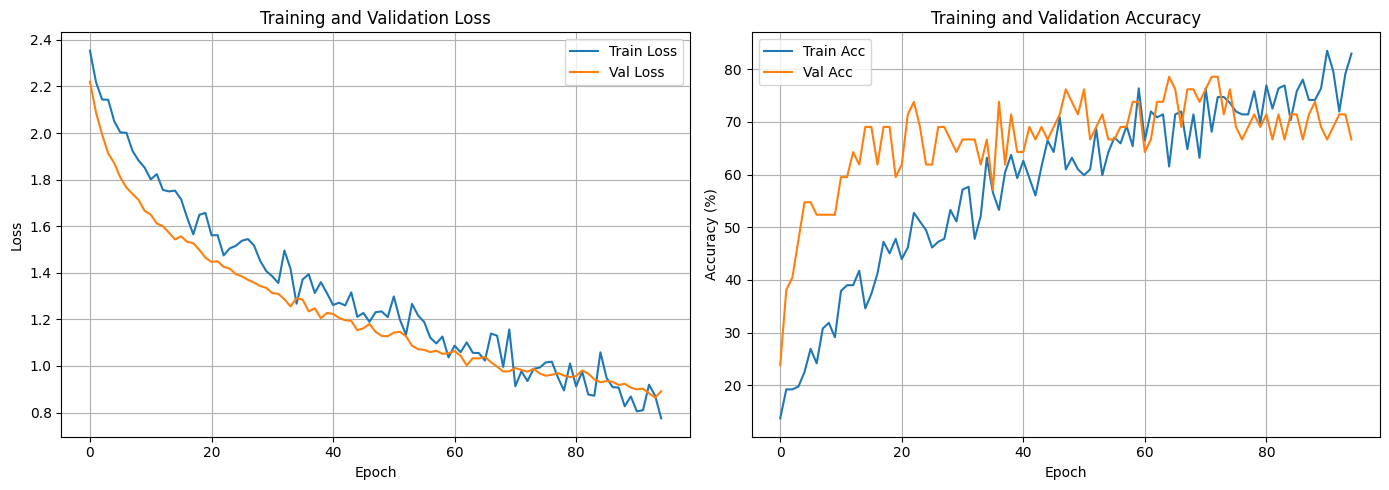


TEST SET EVALUATION RESULTS
Accuracy: 78.57%

F1 Score:
  - Macro: 0.7861
  - Weighted: 0.7793

Precision:
  - Macro: 0.8046
  - Weighted: 0.8002

Recall:
  - Macro: 0.7933
  - Weighted: 0.7857

Mean Average Precision (mAP): 0.8678

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.67      0.33      0.44         6
           3       0.67      0.67      0.67         6
           4       0.56      0.83      0.67         6
           5       0.67      0.80      0.73         5
           6       1.00      0.67      0.80         6
           7       0.83      0.83      0.83         6
           8       0.80      0.80      0.80         5
           9       0.86      1.00      0.92         6

    accuracy                           0.79        56
   macro avg       0.80      0.79      0.79        56
weighted avg       0.80      0

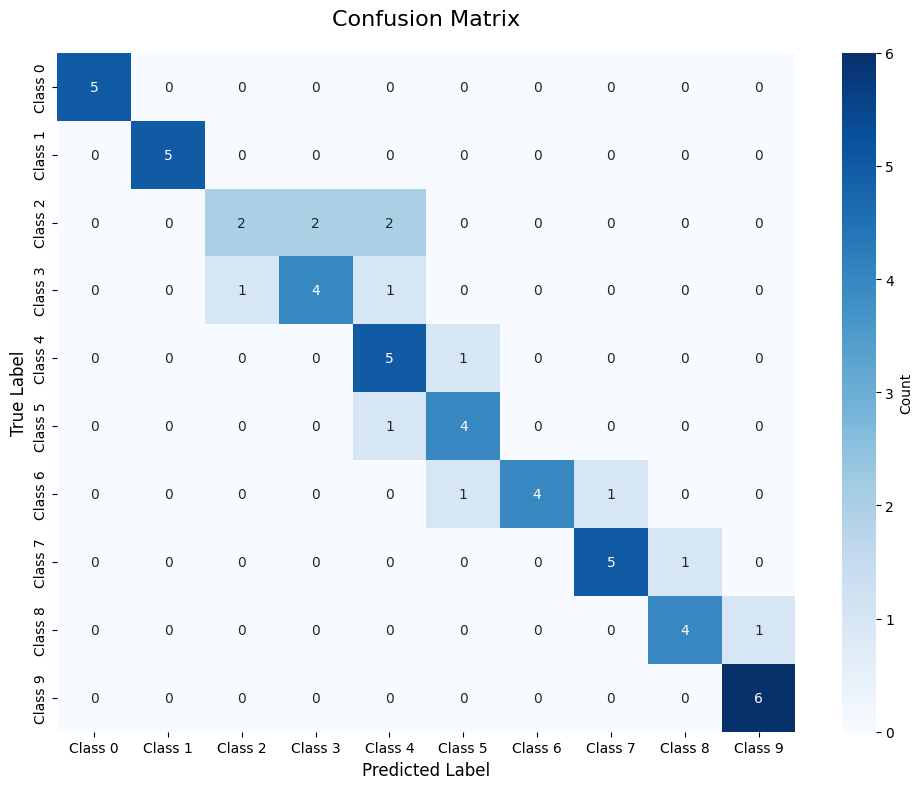


Per-Class Accuracy:
----------------------------------------
Class Class 0: 100.00% (5/5)
Class Class 1: 100.00% (5/5)
Class Class 2: 33.33% (2/6)
Class Class 3: 66.67% (4/6)
Class Class 4: 83.33% (5/6)
Class Class 5: 80.00% (4/5)
Class Class 6: 66.67% (4/6)
Class Class 7: 83.33% (5/6)
Class Class 8: 80.00% (4/5)
Class Class 9: 100.00% (6/6)
----------------------------------------


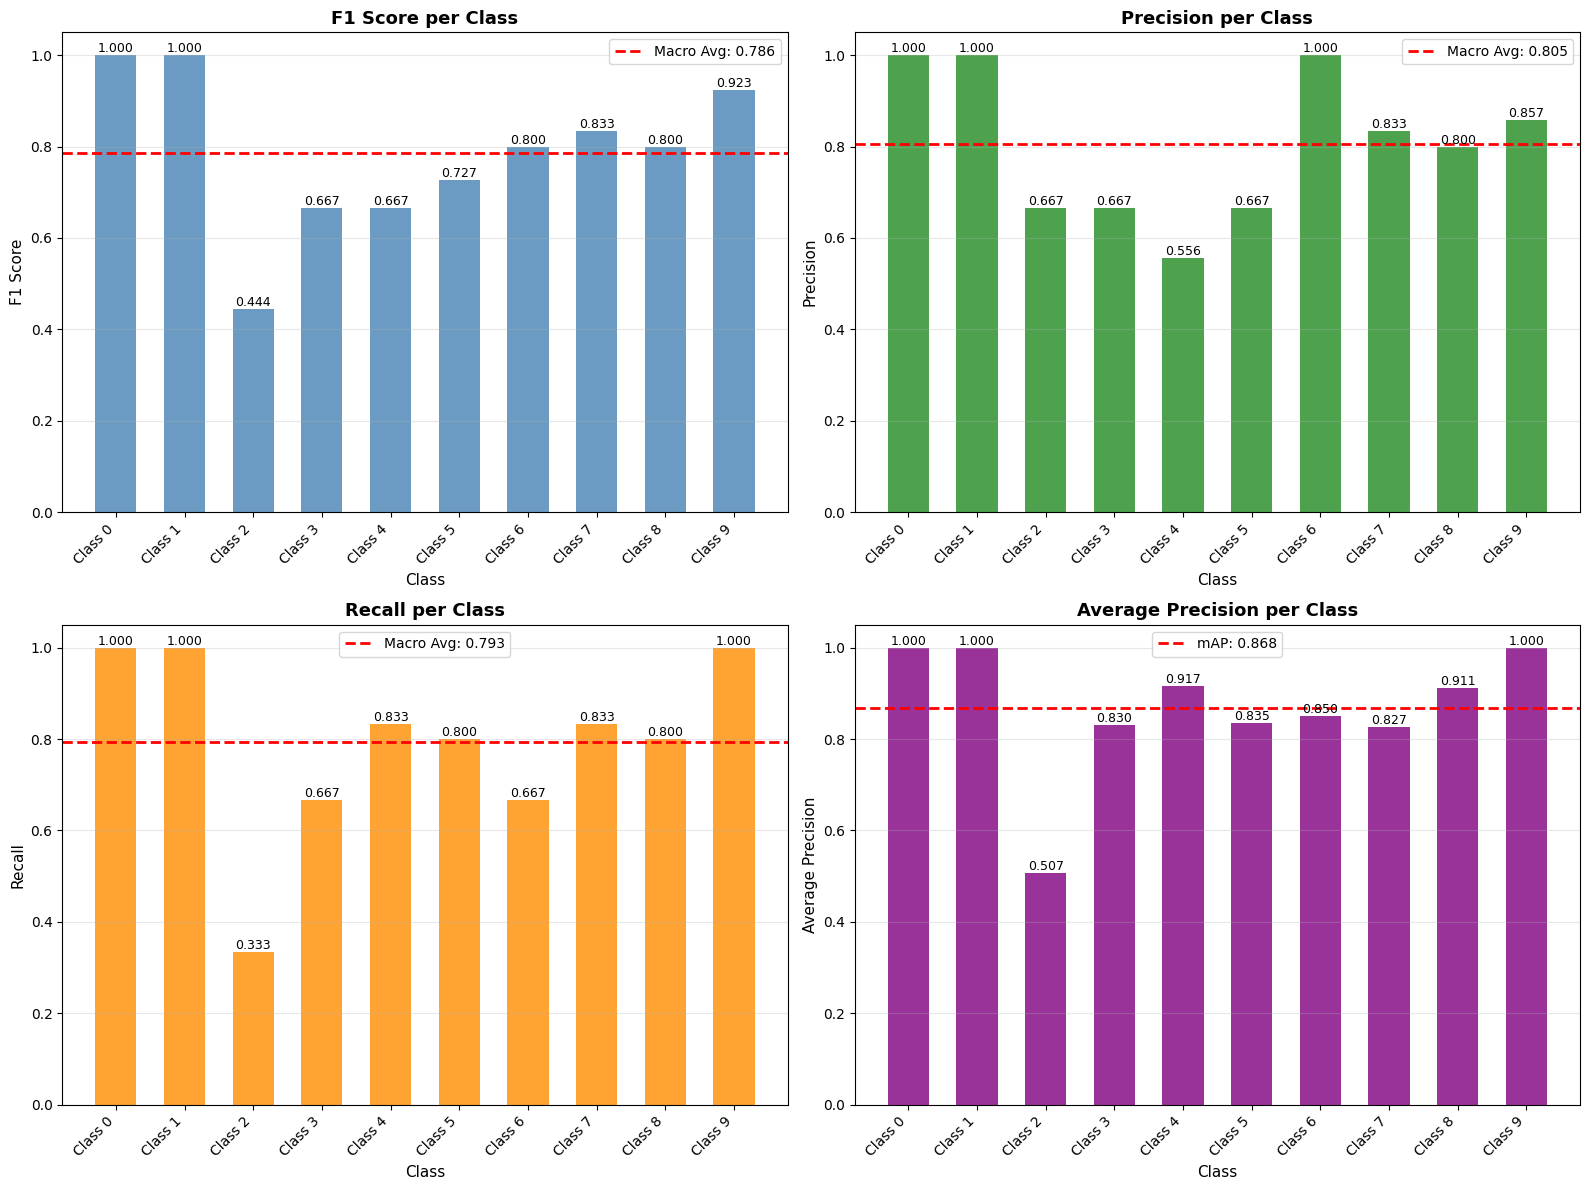

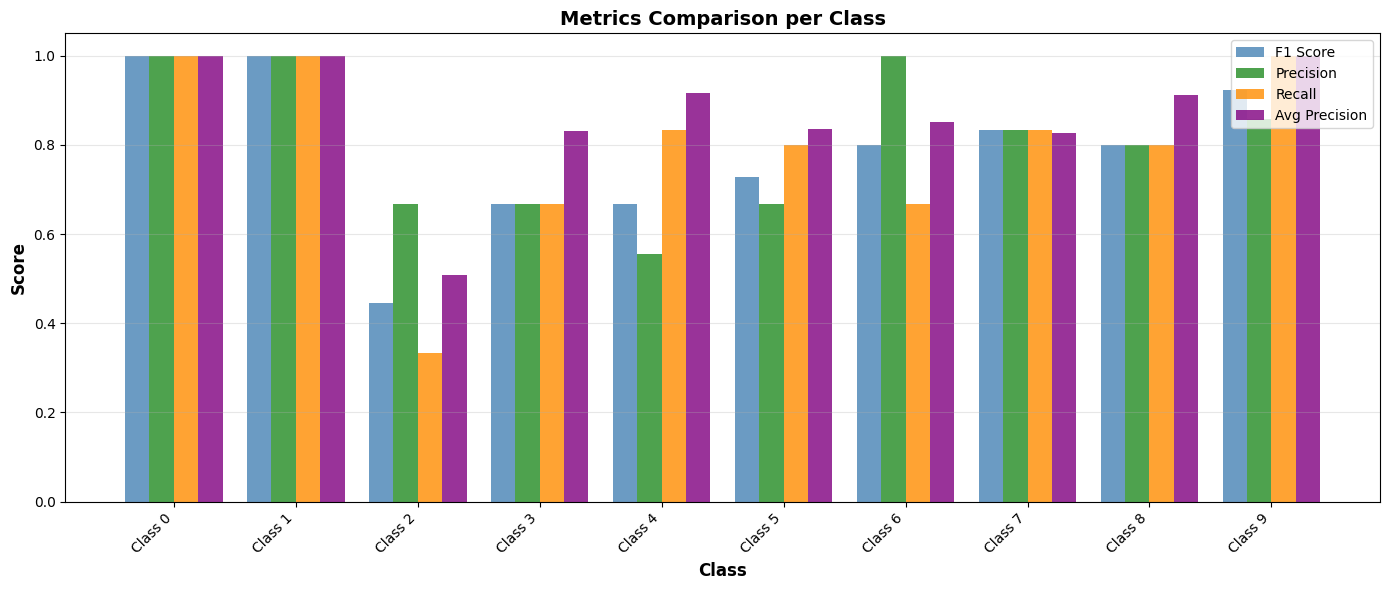


Model saved as eit_autoencoder_model.pth


In [36]:
# {'batch_size': 16, 'learning_rate': 0.0001, 'latent_dim': 256, 'num_epochs': 150}
if __name__ == "__main__":
    # prepare data with smaller batch size
    train_loader, val_loader, test_loader, scaler = prepare_data(
        X, y, test_size=0.2, val_size=0.15, batch_size=16
    )
    
    # initialize simplified model
    # model = EIT_1DCNN(input_size=128, num_classes=10).to(device)
    model = EIT_Autoencoder(input_size=128, num_classes=10, latent_dim=128).to(device)
    print(model)
    print(f'\nTotal parameters: {sum(p.numel() for p in model.parameters())}')
    
    # train model with more epochs and early stopping
    model, history = train_model(
        model, train_loader, val_loader, 
        num_epochs=150, learning_rate=0.0001
    )
    
    # plot training history
    plot_training_history(history)
    
    # test model
    predictions, true_labels, metrics = test_model(model, test_loader, num_classes=10)
    
    # plot confusion matrix
    class_names = [f'Class {i}' for i in range(10)]  # Customize with your class names
    plot_confusion_matrix(true_labels, predictions, class_names=class_names)
    
    # plot metrics per class (4 separate plots)
    plot_metrics_per_class(metrics, class_names=class_names)
    
    # plot metrics comparison (side-by-side comparison)
    plot_metrics_comparison(metrics, class_names=class_names)
    
    # save model and metrics
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'metrics': metrics,
    }, 'torch_models/eit_autoencoder_model.pth')
    print('\nModel saved as eit_autoencoder_model.pth')

Inference

In [ ]:
if __name__ == "__main__":
    # Define the hyperparameter grid
    param_grid = {
        'batch_size': [8, 16, 32],
        'learning_rate': [1e-3, 1e-4, 5e-5],
        'latent_dim': [64, 128, 256],
        'num_epochs': [150, 250],
    }

    # Generate all combinations
    param_combinations = list(itertools.product(
        param_grid['batch_size'],
        param_grid['learning_rate'],
        param_grid['latent_dim'],
        param_grid['num_epochs']
    ))

    total_combinations = len(param_combinations)
    print(f"\n🔍 Starting grid search over {total_combinations} combinations...\n")

    best_val_acc = 0.0
    best_params = None
    best_model_state = None
    best_metrics = None

    # tqdm progress bar
    for (batch_size, learning_rate, latent_dim, num_epochs) in tqdm(
        param_combinations,
        desc="Grid Search Progress",
        total=total_combinations,
        ncols=100
    ):
        tqdm.write(f"\n=== Testing combination ===\n"
                   f"Batch Size: {batch_size}, LR: {learning_rate}, "
                   f"Latent Dim: {latent_dim}, Epochs: {num_epochs}")

        # Prepare data
        train_loader, val_loader, test_loader, scaler = prepare_data(
            X, y, test_size=0.2, val_size=0.15, batch_size=batch_size
        )

        # Initialize model
        model = EIT_Autoencoder(input_size=128, num_classes=10, latent_dim=latent_dim).to(device)

        # Train model
        model, history = train_model(
            model, train_loader, val_loader,
            num_epochs=num_epochs, learning_rate=learning_rate
        )

        # Evaluate on validation set
        _, _, metrics = test_model(model, val_loader, num_classes=10)
        val_acc = metrics.get('overall', {}).get('accuracy', metrics.get('accuracy', 0.0))

        tqdm.write(f"Validation accuracy: {val_acc:.4f}")

        # Update best combination
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'latent_dim': latent_dim,
                'num_epochs': num_epochs
            }
            best_model_state = model.state_dict()
            best_metrics = metrics
            tqdm.write(f"✅ New best model found! Accuracy = {best_val_acc:.4f}")

    print("\n=== 🏆 Best Hyperparameters Found ===")
    print(best_params)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    # Retrain or evaluate best model
    print("\nRetraining final model with best hyperparameters...")
    train_loader, val_loader, test_loader, scaler = prepare_data(
        X, y, test_size=0.2, val_size=0.15, batch_size=best_params['batch_size']
    )

    final_model = EIT_Autoencoder(
        input_size=128,
        num_classes=10,
        latent_dim=best_params['latent_dim']
    ).to(device)
    final_model.load_state_dict(best_model_state)

    # Test final model
    predictions, true_labels, test_metrics = test_model(final_model, test_loader, num_classes=10)

    # Plot results
    class_names = [f'Class {i}' for i in range(10)]
    plot_confusion_matrix(true_labels, predictions, class_names)
    plot_metrics_per_class(test_metrics, class_names)
    plot_metrics_comparison(test_metrics, class_names)

    # Save final model
    torch.save({
        'model_state_dict': final_model.state_dict(),
        'scaler': scaler,
        'metrics': test_metrics,
        'best_params': best_params
    }, 'torch_models/eit_autoencoder_best_model.pth')

    print('\n💾 Best model saved as eit_autoencoder_best_model.pth')


In [17]:
import torch
import torch.nn as nn
import pandas as pd

In [18]:
# Load the checkpoint
checkpoint_path = 'torch_models/eit_1dcnn_model.pth'
# Allow unpickling of the scaler
with torch.serialization.safe_globals([StandardScaler]):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
# Create model and load weights
model = EIT_1DCNN()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
# Load scaler
scaler = checkpoint['scaler']

In [ ]:

def predict_from_row(df_row):

    # Scale the input using saved scaler
    x_scaled = scaler.transform(df_row.values.reshape(1, -1))
    # Convert to tensor [batch, channels, seq_len]
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).unsqueeze(1)
    # Forward pass
    with torch.no_grad():
        output = model(x_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    
    return predicted_class

In [20]:
# Example usage
print("Actual Class:", df['y'].iloc[150])
row_to_predict = df.drop(columns=['y']).iloc[150]
pred_class = predict_from_row(row_to_predict)
print("Predicted class:", pred_class)

Actual Class: 7
Predicted class: 7
